# plotting functions of figure 3 in the manuscript
In this figure we demonstrate the ability to change the SNR of the particles to more accurately approach experimental data.


In [14]:
# imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mrcfile

from emmer.ndimage.filter.smoothen_mask import smoothen_mask
from pipeliner.mrc_image_tools import mrc_thumbnail
from gemmi import cif

# roodmus
from roodmus.analysis.utils import load_data

In [ ]:
# functions

## panel A
plotting an example micrograph and the corresponding power spectrum

[]

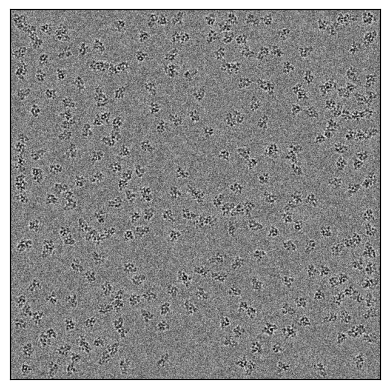

In [2]:
# load the input micrograph and plot a thumbnail
project_dir = "/home/mjoosten1/projects/roodmus/data/20240110_low_exposure_data_reconstruction/"
figures_dir = os.path.join(project_dir, "figures")
input_mrc_filename = os.path.join(project_dir, "CtfFind", "job002", "maarten_thumbnail", "input.mrc")
input_mrc_thumbnail = mrc_thumbnail(
    input_mrc_filename,
    500,
    os.path.join(figures_dir, "input_thumbnail.png"),
)

fig, ax = plt.subplots()
ax.imshow(input_mrc_thumbnail, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

[]

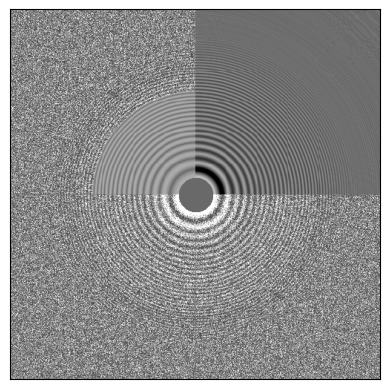

In [3]:
# plot the power specrtrum
diagnostic_filename = os.path.join(project_dir, "CtfFind", "job002", "maarten_thumbnail", "diagnostic_output.mrc")
mrc_thumbnail = mrc_thumbnail(
    diagnostic_filename,
    500,
    os.path.join(figures_dir, "diagnostic_thumbnail.png"),
)

fig, ax = plt.subplots()
ax.imshow(mrc_thumbnail, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

## panel B
precision and recall of particle picking with topaz for different electron dose levels

In [4]:
project_dir = "/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison"
figures_dir = os.path.join(project_dir, "figures")
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True # prints out progress statements
ignore_missing_files = True # if .mrc files are missing, the analysis will still be performed
enable_tqdm = True # enables tqdm progress bars

data = {
    0: {
        "exposure": 45,
        "LoG": "job004",
        "Class2D": "job005",
        "topaz": "job010",
        "homogeneous": "job016"
    },
    1: {
        "exposure": 35,
        "LoG": "job037",
        "Class2D": "job038",
        "topaz": "job042",
        "homogeneous": "job048"
    },
    2: {
        "exposure": 25,
        "LoG": "job054",
        "Class2D": "job055",
        "topaz": "job059",
        "homogeneous": "job065"
    },
    3: {
        "exposure": 15,
        "LoG": "job071",
        "Class2D": "job072",
        "topaz": "job076",
        "homogeneous": "job082"
    },
    4: {
        "exposure": 5,
        "LoG": "job088",
        "Class2D": "job089",
        "topaz": None,
        "homogeneous": None
    },
    5: {
        "exposure": 10,
        "LoG": "job093",
        "Class2D": "job094",
        "topaz": None,
        "homogeneous": None
    },
    6: {
        "exposure": 12,
        "LoG": "job098",
        "Class2D": "job099",
        "topaz": None,
        "homogeneous": None
    },
        7: {
        "exposure": 8,
        "LoG": "job114",
        "Class2D": "job115",
        "topaz": None,
        "homogeneous": None,
    },
}

for key, item in data.items():
    exposure = f"{item['exposure']}".zfill(2)
    config_dir = os.path.join(project_dir, f"mrc_epa_{exposure}")
    print(config_dir)
    meta_files = [
        os.path.join(project_dir, "Extract", item["LoG"], "particles.star"),
        # os.path.join(project_dir, "Class2D", item["Class2D"], "run_it025_data.star"),
    ]
    jobtypes = {
        os.path.join(project_dir, "Extract", item["LoG"], "particles.star"): "LoG",
        os.path.join(project_dir, "Class2D", item["Class2D"], "run_it025_data.star"): "Class2D",
    }
    if item["topaz"]:
        meta_files.append(os.path.join(project_dir, "Extract", item["topaz"], "particles.star"))
        jobtypes[os.path.join(project_dir, "Extract", item["topaz"], "particles.star")] = "topaz"
    if item["homogeneous"]:
        meta_files.append(os.path.join(project_dir, "Refine3D", item["homogeneous"], "run_data.star"))
        jobtypes[os.path.join(project_dir, "Refine3D", item["homogeneous"], "run_data.star")] = "homogeneous"

    for i, meta_file in enumerate(meta_files):
        if i == 0:
            analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
        else:
            analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file
    
    df_picked = pd.DataFrame(analysis.results_picking)
    df_truth = pd.DataFrame(analysis.results_truth)

    # compute precision and recall
    df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)

    # add a column to the picked data frame that indicates exposure
    df_picked["exposure"] = item["exposure"]
    df_precision["exposure"] = item["exposure"]

    df_overlap = analysis.compute_overlap(df_picked, df_truth, verbose=verbose)

    # add a column to the overlap data frame that indicates exposure
    df_overlap["exposure"] = item["exposure"]

    if key == 0:
        df_precision_all = df_precision
        df_picked_all = df_picked
        df_overlap_all = df_overlap
        df_truth_all = df_truth
    else:
        df_precision_all = pd.concat([df_precision_all, df_precision])
        df_picked_all = pd.concat([df_picked_all, df_picked])
        df_overlap_all = pd.concat([df_overlap_all, df_overlap])
        df_truth_all = pd.concat([df_truth_all, df_truth])

jobtypes_all = {}
for value in data.values():
    jobtypes_all[value["LoG"]] = "LoG"
    # jobtypes_all[value["Class2D"]] = "Class2D"
    if value["topaz"]:
        jobtypes_all[value["topaz"]] = "topaz"
    if value["homogeneous"]:
        jobtypes_all[value["homogeneous"]] = "homogeneous"
df_precision_all["job"] = df_precision_all["metadata_filename"].apply(lambda x: x.split("/")[-2])
df_precision_all["jobtype"] = df_precision_all["job"].map(jobtypes_all)
df_picked_all["job"] = df_picked_all["metadata_filename"].apply(lambda x: x.split("/")[-2])
df_picked_all["jobtype"] = df_picked_all["job"].map(jobtypes_all)

/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_45
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job004/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job004/particles.star. determined file type: star


Dictionaries now contain 35912 reconstructed particles
added 35912 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job004/particles.star


loading truth data: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s, micrograph=000099.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 35912 particles and 30000 true particles
Added 30000 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_45
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job010/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job010/particles.star. determined file type: star
checking if ugraphs exist...


Dictionaries now contain 108600 reconstructed particles
added 72688 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job010/particles.star
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Refine3D/job016/run_data.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Refine3D/job016/run_data.star. determined file type: star
checking if u

computing precision: 100%|██████████| 300/300 [00:44<00:00,  6.78it/s, precision=0.919, recall=0.966, multiplicity=0.973]


time taken to compute precision: 44.59528088569641


computing overlap: 100%|██████████| 300/300 [00:02<00:00, 141.71it/s, neighbours_truth=252, neighbours_picked=418]


/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_35
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job037/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job037/particles.star. determined file type: star


Dictionaries now contain 35948 reconstructed particles
added 35948 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job037/particles.star


loading truth data: 100%|██████████| 100/100 [00:25<00:00,  3.86it/s, micrograph=000099.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 35948 particles and 30000 true particles
Added 30000 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_35
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job042/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job042/particles.star. determined file type: star
checking if ugraphs exist...


Dictionaries now contain 105057 reconstructed particles
added 69109 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job042/particles.star
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Refine3D/job048/run_data.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Refine3D/job048/run_data.star. determined file type: star
checking if u

computing precision: 100%|██████████| 300/300 [00:44<00:00,  6.78it/s, precision=0.981, recall=0.893, multiplicity=0.9]  


time taken to compute precision: 44.560072898864746


computing overlap: 100%|██████████| 300/300 [00:01<00:00, 156.08it/s, neighbours_truth=253, neighbours_picked=344]


/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_25
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job054/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job054/particles.star. determined file type: star


Dictionaries now contain 36250 reconstructed particles
added 36250 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job054/particles.star


loading truth data: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, micrograph=000099.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 36250 particles and 30000 true particles
Added 30000 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_25
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job059/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job059/particles.star. determined file type: star
checking if ugraphs exist...


Dictionaries now contain 115395 reconstructed particles
added 79145 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job059/particles.star
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Refine3D/job065/run_data.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Refine3D/job065/run_data.star. determined file type: star
checking if u

computing precision: 100%|██████████| 300/300 [00:47<00:00,  6.36it/s, precision=0.963, recall=0.897, multiplicity=0.91] 


time taken to compute precision: 47.48429489135742


computing overlap: 100%|██████████| 300/300 [00:02<00:00, 141.61it/s, neighbours_truth=224, neighbours_picked=340]   


/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_15
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job071/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job071/particles.star. determined file type: star


Dictionaries now contain 36346 reconstructed particles
added 36346 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job071/particles.star


loading truth data: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s, micrograph=000099.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 36346 particles and 30000 true particles
Added 30000 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_15
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job076/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job076/particles.star. determined file type: star
checking if ugraphs exist...


Dictionaries now contain 95714 reconstructed particles
added 59368 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job076/particles.star
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Refine3D/job082/run_data.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Refine3D/job082/run_data.star. determined file type: star
checking if ug

computing precision: 100%|██████████| 300/300 [00:37<00:00,  8.04it/s, precision=0.97, recall=0.655, multiplicity=0.663] 


time taken to compute precision: 37.555981159210205


computing overlap: 100%|██████████| 300/300 [00:01<00:00, 181.07it/s, neighbours_truth=227, neighbours_picked=250]


/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_05
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job088/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job088/particles.star. determined file type: star


Dictionaries now contain 36201 reconstructed particles
added 36201 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job088/particles.star


loading truth data: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s, micrograph=000099.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 36201 particles and 30000 true particles
Added 30000 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_05
For each micrograph, for each metadata file, compute the precision, recall and multiplicity
Speed of computation depends on the number of particles in the micrograph. progressbar is not accurate
Total number of groups to loop over: 100
Number of micgrographs: 100
Number of metadata files: 1
Starting loop over groups


computing precision: 100%|██████████| 100/100 [00:11<00:00,  8.64it/s, precision=0.426, recall=0.544, multiplicity=0.563]


time taken to compute precision: 11.752346277236938


computing overlap: 100%|██████████| 100/100 [00:00<00:00, 179.52it/s, neighbours_truth=213, neighbours_picked=406]


/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_10
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job093/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job093/particles.star. determined file type: star


Dictionaries now contain 36415 reconstructed particles
added 36415 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job093/particles.star


loading truth data: 100%|██████████| 100/100 [00:25<00:00,  3.89it/s, micrograph=000099.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 36415 particles and 30000 true particles
Added 30000 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_10
For each micrograph, for each metadata file, compute the precision, recall and multiplicity
Speed of computation depends on the number of particles in the micrograph. progressbar is not accurate
Total number of groups to loop over: 100
Number of micgrographs: 100
Number of metadata files: 1
Starting loop over groups


computing precision: 100%|██████████| 100/100 [00:11<00:00,  8.49it/s, precision=0.53, recall=0.681, multiplicity=0.7]  


time taken to compute precision: 11.921754121780396


computing overlap: 100%|██████████| 100/100 [00:00<00:00, 171.48it/s, neighbours_truth=258, neighbours_picked=414]


/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_12
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job098/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job098/particles.star. determined file type: star


Dictionaries now contain 36447 reconstructed particles
added 36447 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job098/particles.star


loading truth data: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s, micrograph=000099.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 36447 particles and 30000 true particles
Added 30000 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_12
For each micrograph, for each metadata file, compute the precision, recall and multiplicity
Speed of computation depends on the number of particles in the micrograph. progressbar is not accurate
Total number of groups to loop over: 100
Number of micgrographs: 100
Number of metadata files: 1
Starting loop over groups


computing precision: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s, precision=0.508, recall=0.637, multiplicity=0.657]


time taken to compute precision: 11.672447443008423


computing overlap: 100%|██████████| 100/100 [00:00<00:00, 180.20it/s, neighbours_truth=243, neighbours_picked=414]


/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_08
loading metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job114/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job114/particles.star. determined file type: star


Dictionaries now contain 36361 reconstructed particles
added 36361 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/Extract/job114/particles.star


loading truth data: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s, micrograph=000099.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 36361 particles and 30000 true particles
Added 30000 particles from /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/mrc_epa_08
For each micrograph, for each metadata file, compute the precision, recall and multiplicity
Speed of computation depends on the number of particles in the micrograph. progressbar is not accurate
Total number of groups to loop over: 100
Number of micgrographs: 100
Number of metadata files: 1
Starting loop over groups


computing precision: 100%|██████████| 100/100 [00:11<00:00,  8.43it/s, precision=0.469, recall=0.609, multiplicity=0.63] 


time taken to compute precision: 11.898929834365845


computing overlap: 100%|██████████| 100/100 [00:00<00:00, 187.31it/s, neighbours_truth=248, neighbours_picked=422]


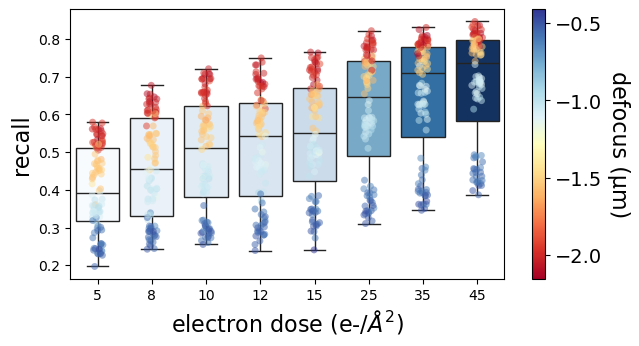

In [11]:
# sort df_precision_all by exposure
df_precision_LoG = df_precision_all.groupby("jobtype").get_group("LoG")

fig, ax = plt.subplots(figsize=(7, 3.5))
# create stripplot for precision per exposure, with different columns for different metadata files
sns.stripplot(x="exposure", y="recall", hue="defocus", data=df_precision_LoG, ax=ax, jitter=0.1, dodge=False, alpha=0.5, legend=False, palette="RdYlBu")
sns.boxplot(x="exposure", y="recall", hue="exposure", data=df_precision_LoG, ax=ax, dodge=False, palette="Blues", legend=False)

ax.set_xlabel("electron dose (e-/$\AA^2$)", fontsize=16)
ax.set_ylabel("recall", fontsize=16)
sm = plt.cm.ScalarMappable(
    cmap="RdYlBu",
    norm=plt.Normalize(
        vmin=df_precision["defocus"].min()/10000,
        vmax=df_precision["defocus"].max()/10000,
    ),
)
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("defocus (\u03BCm)", rotation=270, labelpad=20, fontsize=16)
cbar.ax.tick_params(labelsize=14)

fig.savefig(os.path.join(figures_dir, "recall_vs_exposure.pdf"), bbox_inches="tight")



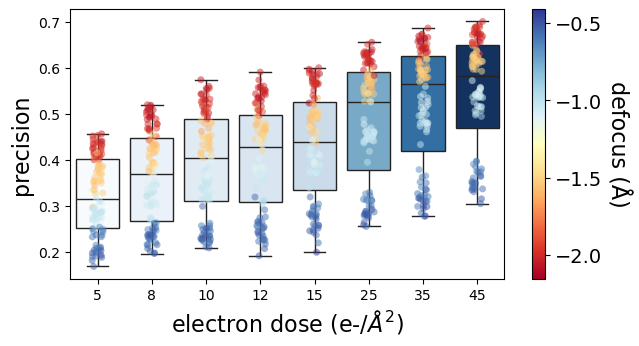

In [12]:
df_precision_LoG = df_precision_all.groupby("jobtype").get_group("LoG")

fig, ax = plt.subplots(figsize=(7, 3.5))
# create stripplot for precision per exposure, with different columns for different metadata files
sns.stripplot(x="exposure", y="precision", hue="defocus", data=df_precision_LoG, ax=ax, jitter=0.1, dodge=False, alpha=0.5, legend=False, palette="RdYlBu")
sns.boxplot(x="exposure", y="precision", hue="exposure", data=df_precision_LoG, ax=ax, dodge=False, palette="Blues", legend=False)

ax.set_xlabel("electron dose (e-/$\AA^2$)", fontsize=16)
ax.set_ylabel("precision", fontsize=16)
sm = plt.cm.ScalarMappable(
    cmap="RdYlBu",
    norm=plt.Normalize(
        vmin=df_precision["defocus"].min()/10000,
        vmax=df_precision["defocus"].max()/10000,
    ),
)
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("defocus (Å)", rotation=270, labelpad=20, fontsize=16)
cbar.ax.tick_params(labelsize=14)

fig.savefig(os.path.join(figures_dir, "precision_vs_exposure.pdf"), bbox_inches="tight")

## panel C
plotting 2D class averages for different electron dose levels (specifically 45, 35, 25, 15 e/A2) 


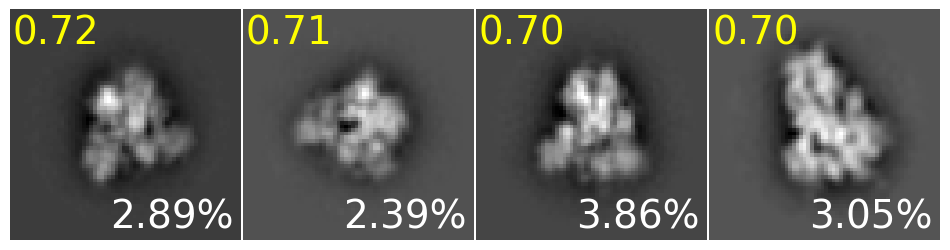

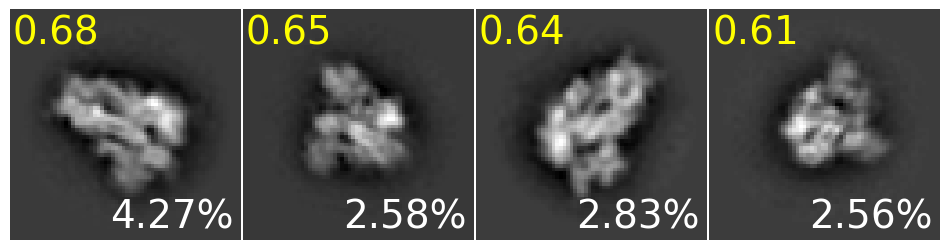

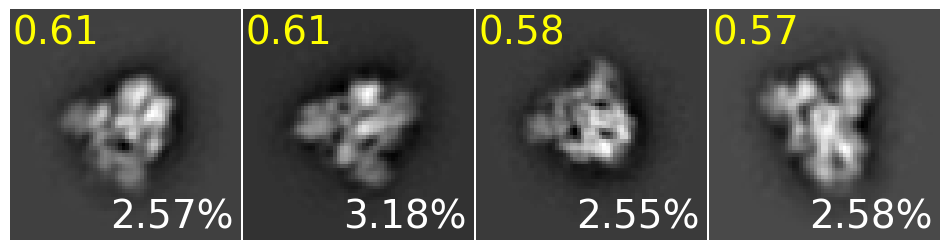

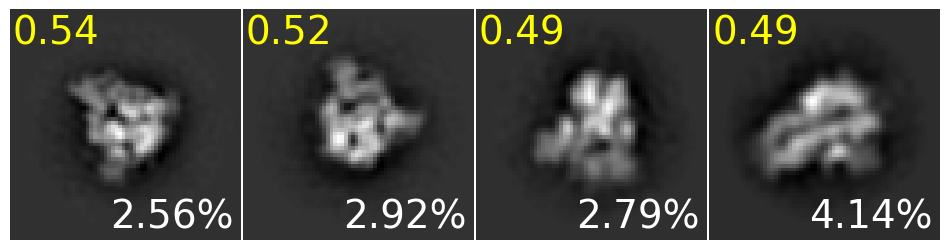

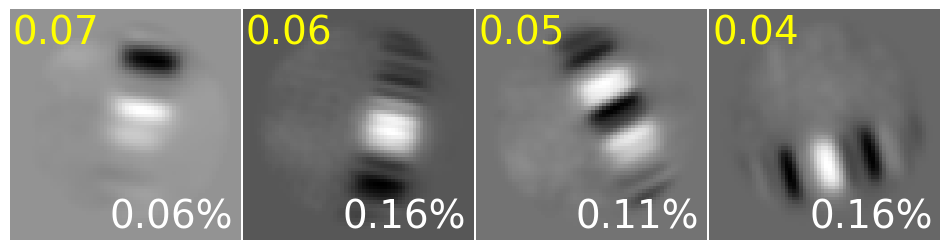

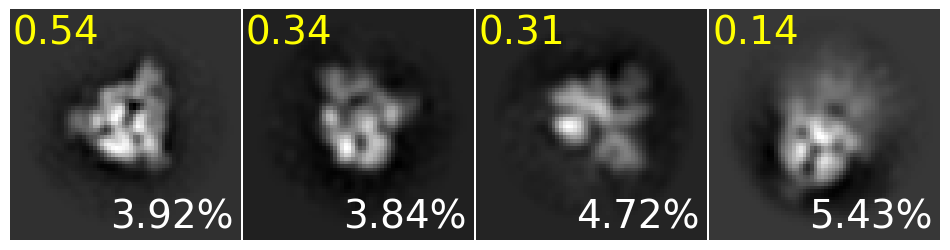

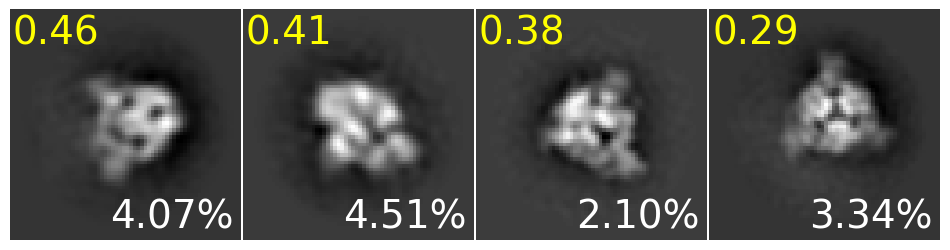

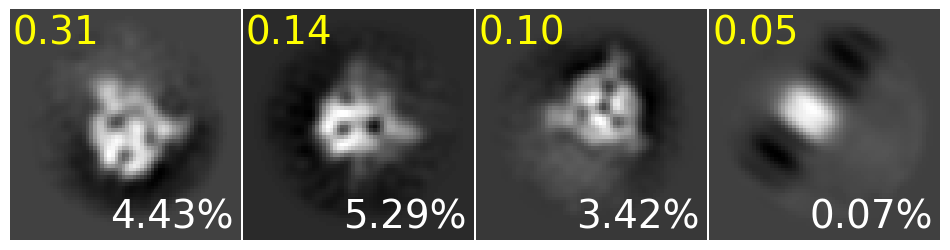

In [17]:
# plotting 2D classes
project_dir = "/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison"
figures_dir = os.path.join(project_dir, "figures")

data = {
    0: {
        "exposure": 45,
        "LoG": "job004",
        "Class2D": "job005",
        "topaz": "job010",
        "homogeneous": "job016",
        "Selection": "job100",
    },
    1: {
        "exposure": 35,
        "LoG": "job037",
        "Class2D": "job038",
        "topaz": "job042",
        "homogeneous": "job048",
        "Selection": "job102",
    },
    2: {
        "exposure": 25,
        "LoG": "job054",
        "Class2D": "job055",
        "topaz": "job059",
        "homogeneous": "job065",
        "Selection": "job103",
    },
    3: {
        "exposure": 15,
        "LoG": "job071",
        "Class2D": "job072",
        "topaz": "job076",
        "homogeneous": "job082",
        "Selection": "job106",
    },
    4: {
        "exposure": 5,
        "LoG": "job088",
        "Class2D": "job089",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job107",
    },
    5: {
        "exposure": 10,
        "LoG": "job093",
        "Class2D": "job094",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job108",
    },
    6: {
        "exposure": 12,
        "LoG": "job098",
        "Class2D": "job099",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job109",
    },
    7: {
        "exposure": 8,
        "LoG": "job114",
        "Class2D": "job115",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job116",
    }
}
N_classes = 4 # number of classes to select

for key, value in data.items():
    rank_starfile = os.path.join(project_dir, "Select", value["Selection"], "rank_model.star")
    rank_cif = cif.read(rank_starfile)
    data_model_classes = rank_cif.find_block("model_classes")
    rlnClassScore = np.array(data_model_classes.find_loop("_rlnClassScore"), dtype=float)
    rlnClassDistribution = np.array(data_model_classes.find_loop("_rlnClassDistribution"), dtype=float)
    rlnEstimatedResolution = np.array(data_model_classes.find_loop("_rlnEstimatedResolution"), dtype=float)

    # get the class averages
    class_average_file = os.path.join(project_dir, "Class2D", value["Class2D"], "run_it025_classes.mrcs")
    class_average = mrcfile.open(class_average_file, mode="r")

    # select the N best classee by class score and plot them with their class score and little space between them
    idx_best_classes = np.argsort(rlnClassScore)[::-1][:N_classes]
    fig, axes = plt.subplots(1, N_classes, figsize=(N_classes * 3, 3))
    for i, idx in enumerate(idx_best_classes):
        axes[i].imshow(class_average.data[idx, :, :], cmap="gray", origin="lower")
        axes[i].text(0.2, 0.9, f"{rlnClassScore[idx]:.2f}", horizontalalignment="center", verticalalignment="center", transform=axes[i].transAxes, color="yellow", fontsize=28)
        axes[i].text(0.7, 0.1, f"{rlnClassDistribution[idx]*100:.2f}%", horizontalalignment="center", verticalalignment="center", transform=axes[i].transAxes, color="white", fontsize=28)
        # axes[i].text(0.2, 0.1, f"{rlnEstimatedResolution[idx]:.2f} $\AA$", horizontalalignment="center", verticalalignment="center", transform=axes[i].transAxes, color="white", fontsize=16)
        axes[i].axis("off")

    # reduce the space between subplots
    fig.subplots_adjust(wspace=0.01)

    # save the figure
    fig.savefig(os.path.join(figures_dir, f"best_classes_{value['exposure']}.pdf"), bbox_inches="tight")


## panel D
plotting the number of particles left after selecting classes with the automatic class selection tool from RELION at a threshold of 0.3 and 0.5. In addition, the plot will show the resolution for the cases where the number of particles remaning is above 4000.

In [19]:
# make a plot of the number of particles selected by automatic class selection as function of the exposure
project_dir = "/home/mjoosten1/projects/roodmus/data/20240110_low_exposure_data_reconstruction"
figures_dir = os.path.join(project_dir, "figures")

data = {
    0: {
        "exposure": 45,
        "auto_selection_0.5": "job006",
        "auto_selection_0.3": "job035",
        "postprocess": "job063"
    },
    1: {
        "exposure": 35,
        "auto_selection_0.5": "job032",
        "auto_selection_0.3": "job034",
        "postprocess": "job066",
    },
    2: {
        "exposure": 25,
        "auto_selection_0.5": "job024",
        "auto_selection_0.3": "job026",
        "postprocess": "job058",
    },
    3: {
        "exposure": 15,
        "auto_selection_0.5": "job017",
        "auto_selection_0.3": "job036",
        "postprocess": None,
    },   
}

result = {
    "exposure": [],
    "auto_selection_0.5": [],
    "auto_selection_0.3": [],
    "postprocess": [],
}

for key, item in data.items():
    result["exposure"].append(item["exposure"])
    print(item["exposure"])

    data_star = os.path.join(project_dir, "Select", item["auto_selection_0.5"], "particles.star")
    data_cif = cif.read_file(data_star)
    particles = data_cif.find_block("particles")
    if particles is not None:
        rlnMicrographName = particles.find_loop("_rlnMicrographName")
        numParticles = len(rlnMicrographName)
        result["auto_selection_0.5"].append(numParticles)
    else:
        result["auto_selection_0.5"].append(0)

    data_star = os.path.join(project_dir, "Select", item["auto_selection_0.3"], "particles.star")
    data_cif = cif.read_file(data_star)
    particles = data_cif.find_block("particles")
    if particles is not None:
        rlnMicrographName = particles.find_loop("_rlnMicrographName")
        numParticles = len(rlnMicrographName)
        result["auto_selection_0.3"].append(numParticles)
    else:
        result["auto_selection_0.3"].append(0)

    if item["postprocess"]:
        postprocess_star = os.path.join(project_dir, "PostProcess", item["postprocess"], "postprocess.star")
        postprocess_cif = cif.read_file(postprocess_star)
        general = postprocess_cif.find_block("general")
        rlnFinalResolution = general.find_value("_rlnFinalResolution")
        result["postprocess"].append(float(rlnFinalResolution))
    else:
        result["postprocess"].append(np.nan)


df = pd.DataFrame(result)
df.head()


45
35
25
15


,exposure,auto_selection_0.5,auto_selection_0.3,postprocess
0,45,6953,11436,2.711864
1,35,3540,10645,2.689076
2,25,1705,4715,3.368421
3,15,0,1701,NaN


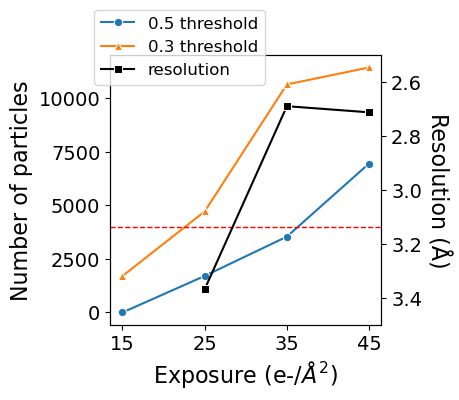

In [37]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.lineplot(x="exposure", y="auto_selection_0.5", data=df, ax=ax, marker="o", label="0.5 threshold")
sns.lineplot(x="exposure", y="auto_selection_0.3", data=df, ax=ax, marker="^", label="0.3 threshold")
ax.set_xlabel("Exposure (e-/$\AA^2$)", fontsize=16)
ax.set_ylabel("Number of particles", fontsize=16)

ax_res = ax.twinx()
sns.lineplot(x="exposure", y="postprocess", data=df, ax=ax_res, marker="s", color="k", label="resolution")
# invert the y-axis
ax_res.invert_yaxis()
ax_res.set_ylim((3.5, 2.5))
ax_res.set_ylabel("Resolution (Å)", fontsize=16, rotation=270, labelpad=20)

ax.tick_params(labelsize=14)
ax_res.tick_params(labelsize=14)
ax.set_xticks([15, 25, 35, 45])

# make 1 combined legend for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_res.get_legend_handles_labels()
ax_res.legend(lines + lines2, labels + labels2, loc=0, fontsize=12, bbox_to_anchor=(0.6, 1.2), ncol=1)
ax.legend().remove()
ax.axhline(4000, color="red", linestyle="--", linewidth=1)

fig.savefig(os.path.join(figures_dir, "auto_selection_vs_exposure.pdf"), bbox_inches="tight")


## panel E
Plot of the average distance between a picked particle and the closest truth particle. This acts as a measurement of the accuracy of the particle picking. The data gets filtered to only include TP particles (i.e. particles that are within 1 particle radius of a truth particle). Because of this, the increase in average distance cannot be explained by more FP particle picks, and only by less precise picking of good particles.

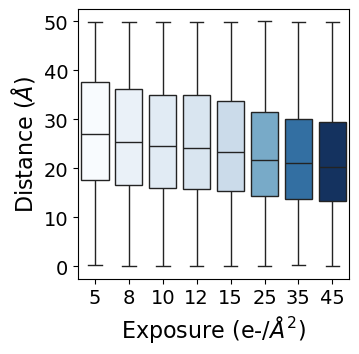

In [41]:
# plot the average distance to the closest particle as a function of exposure
df_picked_all["job"] = df_picked_all["metadata_filename"].apply(lambda x: x.split("/")[-2])
df_picked_all["jobtype"] = df_picked_all["job"].map(jobtypes_all)
df_picked_LoG = df_picked_all[df_picked_all["jobtype"] == "LoG"]
df_picked_LoG_TP = df_picked_LoG.groupby("TP").get_group(True)
fig, ax = plt.subplots(figsize=(3.5, 3.5))
# sns.violinplot(x="exposure", y="closest_dist", data=df_picked_LoG_TP, ax=ax, inner="quartile", palette="Blues", legend=False)
sns.boxplot(x="exposure", y="closest_dist", hue="exposure", data=df_picked_LoG_TP, ax=ax, palette="Blues", legend=False)
# sns.stripplot(x="exposure", y="closest_dist", data=df_picked_LoG_TP, ax=ax, jitter=0.1, dodge=True, alpha=0.5, color="k")
ax.set_xlabel("Exposure (e-/$\AA^2$)", fontsize=16)
ax.set_ylabel("Distance ($\AA$)", fontsize=16)
ax.tick_params(labelsize=14)

fig.savefig(os.path.join(figures_dir, "distance_to_closest_particle_vs_exposure.pdf"), bbox_inches="tight")
